                                        Introduction to Deep Learning
                                            Assignment 1
Name: Indhuja Gudluru
Student ID: 801366046

Problem : 1a

In [380]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
import os
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import seaborn as sns
np.random.seed(123)
torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)


In [381]:
transform = transforms.ToTensor()
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [382]:
# Calculate mean and std
imgs = torch.stack([img_t for img_t, _ in trainset], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)
mean, std

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [383]:
transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])
cifar10_train = datasets.CIFAR10(
    './data', train=True, download=False,
    transform=transform_train)
train_loader = DataLoader(cifar10_train, batch_size=32, shuffle=True, num_workers=2)

In [384]:
transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])
cifar10_val = datasets.CIFAR10(
    './data', train=False, download=False,
    transform=transform_val)
test_loader = DataLoader(cifar10_val, batch_size=32, shuffle=False, num_workers=2)

In [385]:
class_labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [386]:
first_image, label = cifar10_train[0]
print(first_image.shape)

torch.Size([3, 32, 32])


In [387]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*32*32, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 128)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(128, 10) 

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [388]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [389]:
def train_and_evaluate_model(model, criterion, optimizer, train_loader, test_loader, device='cpu'):
    def calculate_metrics(predictions, targets):
        accuracy = 100 * sum([p == t for p, t in zip(all_predictions, all_targets)]) / len(all_targets)
        precision = precision_score(targets, predictions, average='weighted')
        recall = recall_score(targets, predictions, average='weighted')
        f1 = f1_score(targets, predictions, average='weighted')
        return accuracy, precision, recall, f1

    model.to(device)

    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []

    # Training loop
    epochs = 20
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        model.train()
        for i, (inputs,labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss_list.append(running_loss / len(train_loader))
        train_accuracy_list.append(100 * correct / total)

        # Validation loop
        running_loss = 0.0
        correct = 0
        total = 0
        model.eval()
        all_predictions =[]
        all_targets = []
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(test_loader, 0):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_predictions.extend(predicted.tolist())
                all_targets.extend(labels.tolist())

        val_loss_list.append(running_loss / len(test_loader))
        val_accuracy = 100 * correct / total
        val_accuracy_list.append(val_accuracy)

        print(f'Epoch {epoch + 1}, Training loss: {train_loss_list[-1]:.4f}, Validation loss: {val_loss_list[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Final evaluation
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader, 0):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.tolist())
            all_targets.extend(targets.tolist())

    accuracy, precision, recall, f1 = calculate_metrics(all_predictions, all_targets)

    # Print the metrics
    print(f'\nFinal Evaluation Metrics:')
    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Return metrics
    return {
        'train_loss': train_loss_list,
        'train_accuracy':train_accuracy_list,
        'val_loss': val_loss_list,
        'val_accuracy': val_accuracy_list,
        'final_accuracy': accuracy,
        'final_precision': precision,
        'final_recall': recall,
        'final_f1': f1,
        'all_targets': all_targets,
        'all_predictions': all_predictions,
        'model': model
    }

In [390]:

model = MLP().to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [391]:
metrics = train_and_evaluate_model(model, criterion, optimizer, train_loader, test_loader)

Epoch 1, Training loss: 1.7680, Validation loss: 1.5871, Validation Accuracy: 43.87%
Epoch 2, Training loss: 1.5112, Validation loss: 1.4716, Validation Accuracy: 48.51%
Epoch 3, Training loss: 1.3992, Validation loss: 1.4155, Validation Accuracy: 49.60%
Epoch 4, Training loss: 1.3163, Validation loss: 1.3822, Validation Accuracy: 50.98%
Epoch 5, Training loss: 1.2472, Validation loss: 1.3412, Validation Accuracy: 52.49%
Epoch 6, Training loss: 1.1837, Validation loss: 1.3585, Validation Accuracy: 52.15%
Epoch 7, Training loss: 1.1279, Validation loss: 1.3542, Validation Accuracy: 52.65%
Epoch 8, Training loss: 1.0727, Validation loss: 1.3164, Validation Accuracy: 54.30%
Epoch 9, Training loss: 1.0207, Validation loss: 1.3546, Validation Accuracy: 53.25%
Epoch 10, Training loss: 0.9738, Validation loss: 1.3657, Validation Accuracy: 53.49%
Epoch 11, Training loss: 0.9243, Validation loss: 1.3778, Validation Accuracy: 53.40%
Epoch 12, Training loss: 0.8795, Validation loss: 1.3678, Valid

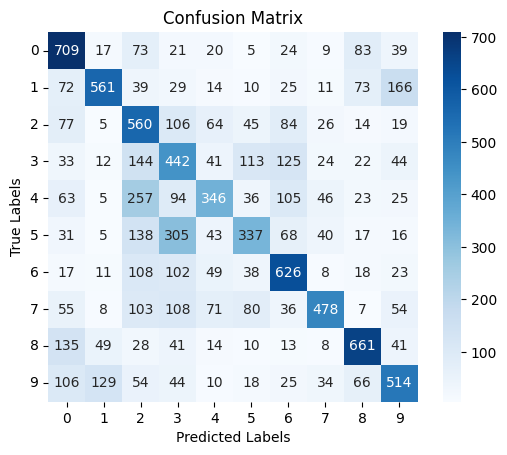

In [392]:
conf_mat = confusion_matrix(metrics['all_targets'], metrics['all_predictions'])
numeric_labels = np.arange(10)
sns.heatmap(conf_mat,square=True, annot=True, fmt='d', cmap='Blues', xticklabels=numeric_labels, yticklabels=numeric_labels)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.ylim(len(conf_mat), 0)
plt.show()

In [393]:
total_params = sum(p.numel() for p in metrics['model'].parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 1640330


In [394]:
epochs_list = [i for i in range(1, 21)]

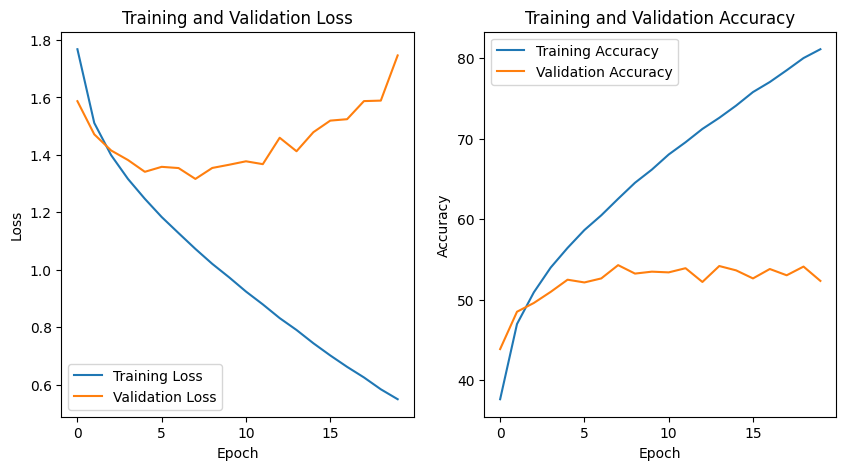

In [395]:
# Plotting training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['train_loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(metrics['train_accuracy'], label='Training Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1b

In [397]:
class MLP2(nn.Module):
    def __init__(self):
        super(MLP2, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 32 * 3, 1024)  
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1024, 512)
        self.relu = nn.ReLU()  
        self.fc3 = nn.Linear(512, 256)
        self.relu = nn.ReLU()  
        self.fc4 = nn.Linear(256, 128)
        self.relu = nn.ReLU()   
        self.fc5 = nn.Linear(128, 10)  
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        return x

In [398]:
Model2 = MLP2().to(device)
# Loss function and optimizer
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(Model2.parameters(), lr=0.01)

In [399]:
model2_metrics = train_and_evaluate_model(Model2, criterion2, optimizer2, train_loader, test_loader)

Epoch 1, Training loss: 2.0437, Validation loss: 1.7688, Validation Accuracy: 35.93%
Epoch 2, Training loss: 1.6552, Validation loss: 1.5593, Validation Accuracy: 44.73%
Epoch 3, Training loss: 1.4879, Validation loss: 1.4655, Validation Accuracy: 47.71%
Epoch 4, Training loss: 1.3790, Validation loss: 1.4627, Validation Accuracy: 48.73%
Epoch 5, Training loss: 1.2914, Validation loss: 1.4115, Validation Accuracy: 50.31%
Epoch 6, Training loss: 1.2181, Validation loss: 1.3491, Validation Accuracy: 52.95%
Epoch 7, Training loss: 1.1468, Validation loss: 1.3407, Validation Accuracy: 53.50%
Epoch 8, Training loss: 1.0817, Validation loss: 1.3282, Validation Accuracy: 53.79%
Epoch 9, Training loss: 1.0183, Validation loss: 1.3481, Validation Accuracy: 53.52%
Epoch 10, Training loss: 0.9575, Validation loss: 1.3522, Validation Accuracy: 54.19%
Epoch 11, Training loss: 0.8948, Validation loss: 1.3385, Validation Accuracy: 54.82%
Epoch 12, Training loss: 0.8278, Validation loss: 1.4097, Valid

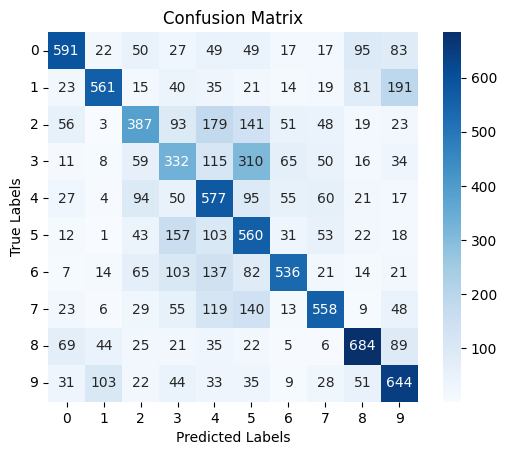

In [400]:
conf_mat = confusion_matrix(model2_metrics['all_targets'], model2_metrics['all_predictions'])
numeric_labels = np.arange(10)
sns.heatmap(conf_mat,square=True, annot=True, fmt='d', cmap='Blues', xticklabels=numeric_labels, yticklabels=numeric_labels)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.ylim(len(conf_mat), 0)
plt.show()

In [401]:
total_params = sum(p.numel() for p in model2_metrics['model'].parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 3837066


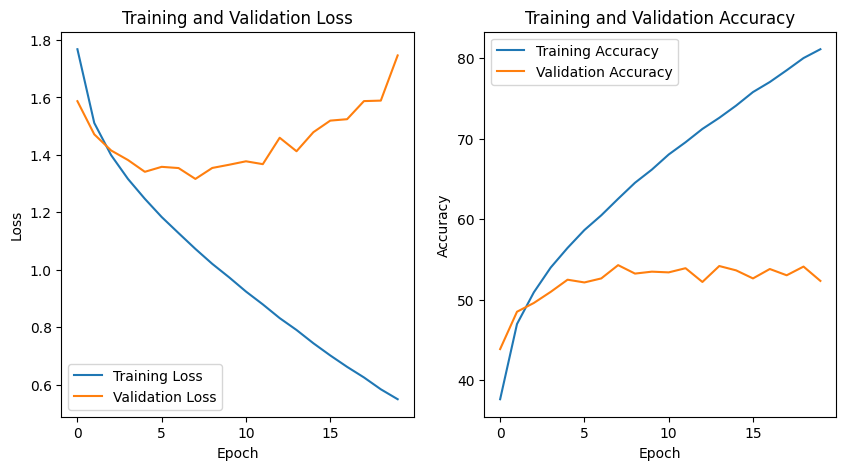

In [402]:
# Plotting training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['train_loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(metrics['train_accuracy'], label='Training Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [403]:
from sklearn.metrics import mean_squared_error

2a

In [408]:
url = 'https://raw.githubusercontent.com/indhu68/Intro_To_DL/main/house-train.csv'
df = pd.read_csv(url)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [410]:
# Define useful columns and preprocess the dataset
usefull_columns = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath',
                'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'LotFrontage', 'WoodDeckSF',
                'OpenPorchSF']
target_column = 'SalePrice'

In [411]:
df_train_prepro = df[usefull_columns + [target_column]].copy()


In [412]:
df_train_prepro.fillna(df_train_prepro.mean(), inplace=True)

In [413]:
# Split data into train and validation sets
X = df_train_prepro[usefull_columns]
y = df_train_prepro[target_column]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [414]:
# Scale the features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [415]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

In [416]:
# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor.view(-1, 1))
val_dataset = TensorDataset(X_val_tensor, y_val_tensor.view(-1, 1))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [417]:
class MLP3(nn.Module):
    def __init__(self, input_size):
        super(MLP3, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.relu(x)
        return self.fc4(x)

In [418]:
model = MLP3(len(usefull_columns))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [419]:
# Training loop
num_epochs = 40
train_loss_list1 = []
val_loss_list1 = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs1, target1 in train_loader:
        optimizer.zero_grad()
        output = model(inputs1)
        loss = criterion(output, target1)
        rmse_loss = torch.sqrt(loss)  
        rmse_loss.backward()
        optimizer.step()
        total_loss += rmse_loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_loss_list1.append(avg_train_loss)

    # Validation
    model.eval()
    predict= []
    true = []
    total_val_loss = 0
    with torch.no_grad():
        for inputs1, target1 in val_loader:
            output = model(inputs1)
            predict.extend(output.view(-1).tolist())
            true.extend(target1.view(-1).tolist())
            loss = criterion(output, target1)
            rmse_loss = torch.sqrt(loss)  
            total_val_loss += rmse_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_list1.append(avg_val_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
mse = mean_squared_error(true, predict)
rmse = mse**0.5
print(f'Final Validation RMSE:{rmse:.4f}')




Epoch 1/40, Training Loss: 196120.7546, Validation Loss: 196708.5703
Epoch 2/40, Training Loss: 196448.8598, Validation Loss: 196645.1109
Epoch 3/40, Training Loss: 196174.2720, Validation Loss: 196279.5125
Epoch 4/40, Training Loss: 195450.3594, Validation Loss: 194985.7375
Epoch 5/40, Training Loss: 193301.3910, Validation Loss: 191614.4750
Epoch 6/40, Training Loss: 188012.3298, Validation Loss: 184530.6047
Epoch 7/40, Training Loss: 178336.6668, Validation Loss: 171998.4344
Epoch 8/40, Training Loss: 162106.7103, Validation Loss: 151722.0297
Epoch 9/40, Training Loss: 138867.4354, Validation Loss: 124233.1750
Epoch 10/40, Training Loss: 111216.4573, Validation Loss: 95792.1047
Epoch 11/40, Training Loss: 89903.9386, Validation Loss: 77314.8902
Epoch 12/40, Training Loss: 81229.0103, Validation Loss: 70770.0297
Epoch 13/40, Training Loss: 77371.6420, Validation Loss: 67820.7219
Epoch 14/40, Training Loss: 74753.5396, Validation Loss: 65307.3828
Epoch 15/40, Training Loss: 72270.7353

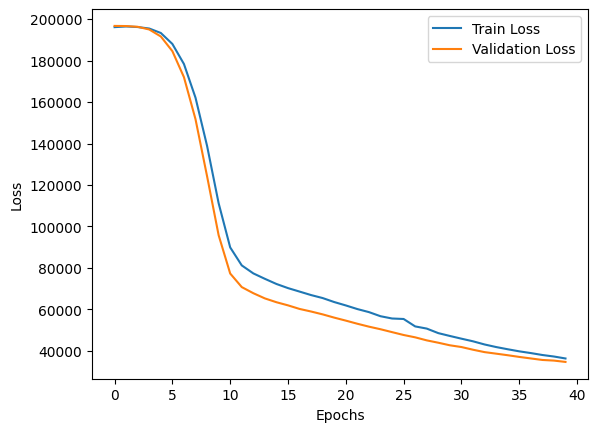

In [420]:
# Plot training and validation loss
plt.plot(train_loss_list1, label='Train Loss')
plt.plot(val_loss_list1, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [421]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 11905


2b

In [422]:
useful_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath',
               'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'LotFrontage', 'WoodDeckSF',
               'OpenPorchSF', 'ExterQual', 'Neighborhood', 'MSZoning', 'Alley', 'LotShape', 
               'LandContour', 'Condition1', 'HouseStyle', 'MasVnrType', 'SaleCondition']
target_col = 'SalePrice'

In [423]:
df_train_prepro = df[useful_cols + [target_col]].copy()

In [424]:
numeric_columns = df_train_prepro.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = df_train_prepro.select_dtypes(exclude=[np.number]).columns.tolist()

In [425]:
df_train_prepro[numeric_columns] = df_train_prepro[numeric_columns].fillna(df_train_prepro[numeric_columns].mean())


In [426]:
for col in categorical_columns:
    df_train_prepro[col] = df_train_prepro[col].fillna(df_train_prepro[col].mode()[0])

In [427]:
# One-hot encoding for categorical features
categorical_features = ['ExterQual', 'Neighborhood', 'MSZoning', 'Alley', 'LotShape', 
                        'LandContour', 'Condition1', 'HouseStyle', 'MasVnrType', 'SaleCondition']
df_train_prepro = pd.get_dummies(df_train_prepro, columns=categorical_features)


In [428]:
# Split data into train and validation sets
X = df_train_prepro.drop(target_col, axis=1)
y = df_train_prepro[target_col]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [429]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [430]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

In [431]:
# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [433]:
class MLP4(nn.Module):
    def __init__(self, input_size):
        super(MLP4, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        return self.fc4(x)

In [434]:
model = MLP4(X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [435]:
# Training loop
num_epochs = 40
train_loss_list1 = []
val_loss_list1 = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs1, target1 in train_loader:
        optimizer.zero_grad()
        output = model(inputs1)
        loss = criterion(output, target1)
        rmse_loss = torch.sqrt(loss)  
        rmse_loss.backward()
        optimizer.step()
        total_loss += rmse_loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_loss_list1.append(avg_train_loss)

    # Validation
    model.eval()
    predict= []
    true = []
    total_val_loss = 0
    with torch.no_grad():
        for inputs1, target1 in val_loader:
            output = model(inputs1)
            predict.extend(output.view(-1).tolist())
            true.extend(target1.view(-1).tolist())
            loss = criterion(output, target1)
            rmse_loss = torch.sqrt(loss)  
            total_val_loss += rmse_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_list1.append(avg_val_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
mse = mean_squared_error(true, predict)
rmse = mse**0.5
print(f'Final Validation RMSE:{rmse:.4f}')




Epoch 1/40, Training Loss: 196205.1382, Validation Loss: 199341.5250
Epoch 2/40, Training Loss: 195797.8627, Validation Loss: 199333.9906
Epoch 3/40, Training Loss: 196438.6859, Validation Loss: 199299.8531
Epoch 4/40, Training Loss: 197146.5140, Validation Loss: 199185.4094
Epoch 5/40, Training Loss: 195311.8758, Validation Loss: 198880.8219
Epoch 6/40, Training Loss: 195497.5016, Validation Loss: 198196.7500
Epoch 7/40, Training Loss: 195812.3421, Validation Loss: 196844.1750
Epoch 8/40, Training Loss: 195252.7196, Validation Loss: 194435.2469
Epoch 9/40, Training Loss: 191196.8997, Validation Loss: 190466.8750
Epoch 10/40, Training Loss: 185628.6776, Validation Loss: 184348.8531
Epoch 11/40, Training Loss: 177760.2993, Validation Loss: 175609.2188
Epoch 12/40, Training Loss: 168342.9745, Validation Loss: 163674.0156
Epoch 13/40, Training Loss: 155929.2664, Validation Loss: 148326.4375
Epoch 14/40, Training Loss: 139530.8516, Validation Loss: 129739.6594
Epoch 15/40, Training Loss: 1

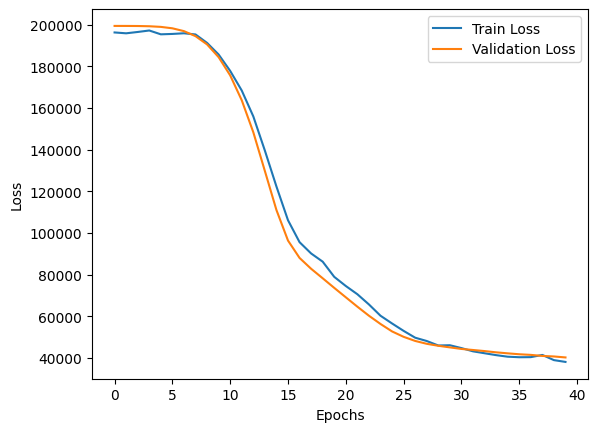

In [436]:
# Plot training and validation loss
plt.plot(train_loss_list1, label='Train Loss')
plt.plot(val_loss_list1, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [437]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 20865


2C

In [439]:
class MLP5(nn.Module):
    def __init__(self, input_size):
        super(MLP5, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)  
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 1)  
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc6(self.relu(self.fc5(x)))  
        return x

In [440]:
#input_size = X_train_tensor.shape[1]
model = MLP5(X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [441]:
# Training loop
num_epochs = 40
train_loss_list1 = []
val_loss_list1 = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs1, target1 in train_loader:
        optimizer.zero_grad()
        output = model(inputs1)
        loss = criterion(output, target1)
        rmse_loss = torch.sqrt(loss)  
        rmse_loss.backward()
        optimizer.step()
        total_loss += rmse_loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_loss_list1.append(avg_train_loss)

    # Validation
    model.eval()
    predict= []
    true = []
    total_val_loss = 0
    with torch.no_grad():
        for inputs1, target1 in val_loader:
            output = model(inputs1)
            predict.extend(output.view(-1).tolist())
            true.extend(target1.view(-1).tolist())
            loss = criterion(output, target1)
            rmse_loss = torch.sqrt(loss)  
            total_val_loss += rmse_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_list1.append(avg_val_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
mse = mean_squared_error(true, predict)
rmse = mse**0.5
print(f'Final Validation RMSE:{rmse:.4f}')




Epoch 1/40, Training Loss: 198032.2969, Validation Loss: 199216.5187
Epoch 2/40, Training Loss: 196709.7492, Validation Loss: 193708.7781
Epoch 3/40, Training Loss: 167607.1287, Validation Loss: 113157.2750
Epoch 4/40, Training Loss: 73555.4969, Validation Loss: 48623.1633
Epoch 5/40, Training Loss: 38378.2303, Validation Loss: 37695.3215
Epoch 6/40, Training Loss: 32536.0659, Validation Loss: 34370.6813
Epoch 7/40, Training Loss: 29858.3702, Validation Loss: 32409.1250
Epoch 8/40, Training Loss: 26856.0190, Validation Loss: 31401.8438
Epoch 9/40, Training Loss: 26105.8715, Validation Loss: 30693.7125
Epoch 10/40, Training Loss: 25263.6849, Validation Loss: 31351.8395
Epoch 11/40, Training Loss: 24424.2974, Validation Loss: 31097.0332
Epoch 12/40, Training Loss: 23547.0508, Validation Loss: 31118.8176
Epoch 13/40, Training Loss: 23823.3574, Validation Loss: 29809.1063
Epoch 14/40, Training Loss: 22233.4308, Validation Loss: 30201.0195
Epoch 15/40, Training Loss: 21697.6297, Validation 

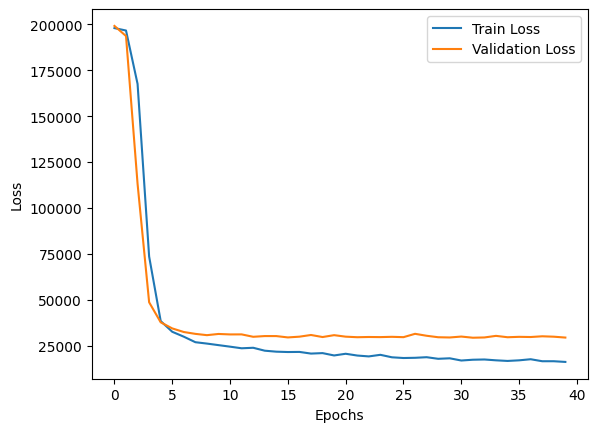

In [442]:
# Plot training and validation loss
plt.plot(train_loss_list1, label='Train Loss')
plt.plot(val_loss_list1, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [443]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 781313
